# CSC 671 Deep Learning Final Project - Connect 4 MLP - Fall 2024
by Donovan Taylor, Joyce Fu, Tyron Cheung, and Randale Reyes (SFSU)

## Import our libraries

In [ ]:
# Import necessary libraries
import numpy as np
import random as rand
import ipywidgets as widgets
from IPython.display import display, clear_output
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterSampler

# GAME

## This is our game logic, this goes at the top and is used by various instances of our game (run first)

In [ ]:
# Function to evaluate the board and get recommended move out of the valid columns
def recommend_valid_move(board, valid_columns):
    # Flatten the board and convert to tensor
    flattened_board = torch.tensor(board.flatten(), dtype=torch.float32)
    # generate our model's output
    output = model(flattened_board)
    new_output = []
    # loop through all 7 possible columns
    for i in range(len(output)):
        # if the current column is a valid column,
        if i in valid_columns:
            # append the current column
            new_output.append(output[i])
        else:
            # else append negative infinity so it's ignored by argmax
            new_output.append(-np.Infinity)
    # generate recommended column from the available columns
    recommended_column = torch.argmax(torch.tensor(new_output)).item()
    return recommended_column

# Function to evaluate the board and get recommended move
def recommend_move(board):
    # Flatten the board and convert to tensor
    flattened_board = torch.tensor(board.flatten(), dtype=torch.float32)
    # generate our model's output
    output = model(flattened_board)
    # generate recommended column
    recommended_column = torch.argmax(output).item()
    return recommended_column

In [ ]:
# Initialize the game board
def initialize_board():
    """Creates an empty 6x7 Connect 4 board."""
    return np.zeros((6, 7))

# Function to check if a location is valid
def is_valid_location(board, col):
    """Checks if a column has space for a new piece."""
    return board[0][col] == 0

# Function to get the next open row in a column
def get_next_open_row(board, col):
    """Finds the next open row in a column for a piece to drop."""
    for r in range(5, -1, -1):
        if board[r][col] == 0:
            return r

# Function to drop a piece into the board
def drop_piece(board, row, col, piece):
    """Drops a piece into the specified row and column."""
    board[row][col] = piece

# Function to check for a winning move and return the winning coordinates
def winning_move(board, piece):
    """Checks if the current move resulted in a win and returns the winning coordinates."""
    # Check horizontal locations for win
    for c in range(4):
        for r in range(5, -1, -1):
            if board[r][c] == piece and board[r][c+1] == piece and board[r][c+2] == piece and board[r][c+3] == piece:
                return True, [(r, c), (r, c+1), (r, c+2), (r, c+3)]

    # Check vertical locations for win
    for c in range(7):
        for r in range(5, 2, -1):
            if board[r][c] == piece and board[r-1][c] == piece and board[r-2][c] == piece and board[r-3][c] == piece:
                return True, [(r, c), (r-1, c), (r-2, c), (r-3, c)]

    # Check positively sloped diagonals
    for c in range(4):
        for r in range(5, 2, -1):
            if board[r][c] == piece and board[r-1][c+1] == piece and board[r-2][c+2] == piece and board[r-3][c+3] == piece:
                return True, [(r, c), (r-1, c+1), (r-2, c+2), (r-3, c+3)]

    # Check negatively sloped diagonals
    for c in range(4):
        for r in range(2, -1, -1):
            if board[r][c] == piece and board[r+1][c+1] == piece and board[r+2][c+2] == piece and board[r+3][c+3] == piece:
                return True, [(r, c), (r+1, c+1), (r+2, c+2), (r+3, c+3)]

    return False, []

# Function to display the board normally
def print_board(board, winning_coords):
    """Prints the board in a readable format."""
    symbol_map = {1: 'x', -1: 'o', 0: '.'}
    for row in range(6):
        for cell in range(7):
          symbol = symbol_map[board[row][cell]]
          if (row, cell) in winning_coords:
            print(f"{symbol.upper()}", end=" ")
          else:
            print(f"{symbol}" , end=" ")
        print()
    print()


## (OPTIONAL) Test game loop

In [ ]:
# Main game loop
def game():
    board = initialize_board()
    game_over = False
    player_turn = 1

    # Create interactive buttons
    buttons = []
    for i in range(7):
        button = widgets.Button(description=str(i+1), layout=widgets.Layout(width='30px'))
        button.on_click(lambda b, col=i: drop_piece_and_print(board, col, player_turn))
        buttons.append(button)


    def drop_piece_and_print(board, col, piece):
        nonlocal player_turn, game_over
        if game_over:
            return


        if is_valid_location(board, col):
            clear_output()
            row = get_next_open_row(board, col)
            drop_piece(board, row, col, piece)
            valid_columns = [col for col in range(7) if is_valid_location(board, col)]
            print_board(board, [])
            display(widgets.HBox(buttons))
            print(recommend_move(board) + 1)

            won, winning_coords = winning_move(board, player_turn)
            if won:
                print_board(board, winning_coords)
                winner = "X" if player_turn == 1 else "O"
                print(f"Player {winner} wins!")
                print("Winning coordinates:", winning_coords)
                return player_turn  # Return the winning player


            # Switch players
            player_turn *= -1

    # Display the initial board and buttons
    print_board(board, [])
    display(widgets.HBox(buttons))

# Run the game function to start the game
game()

. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . x . . 



4


# Generate Dataset

## Functions to play simulated games and generate our dataset

In [ ]:
def generate_game_dataset(num_games, output_file="connect4_dataset.csv"):
    """
    Generates a dataset of random games, recording the board state at each move.

    Args:
    - num_games: Number of games to simulate.
    - output_file: File name for the output CSV.

    Output:
    - A CSV file with rows representing games and columns representing moves.
      Each cell contains a flattened 6x7 board state as a list.
    """
    dataset = []

    for game_id in range(num_games):
        board = initialize_board()
        game_states = []  # Stores flattened board states for this game
        game_over = False
        player_turn = rand.choice([-1, 1])  # Random starting player
        moves_played = 0
        max_moves = 42  # Maximum moves for a Connect 4 board

        while moves_played < max_moves and not game_over:
            valid_columns = [col for col in range(7) if is_valid_location(board, col)]
            if not valid_columns:
                break  # No valid moves left

            # Random move
            column = np.random.choice(valid_columns)
            row = get_next_open_row(board, column)
            drop_piece(board, row, column, player_turn)

            dataset.append({
                "Game_ID": game_id,
                "Player": player_turn,
                "Board_State": board.flatten().tolist(),
                "Column_Played": column
            })

            # Check for a win
            won, _ = winning_move(board, player_turn)
            if won: game_over = True

            # Switch player
            player_turn *= -1
            moves_played += 1

    # Convert dataset to a CSV format
    df = pd.DataFrame(dataset)
    df.to_csv(output_file, index=False)
    print(f"Dataset saved to {output_file}")


## Actually generate the dataset

In [ ]:
# generate our dataset
generate_game_dataset(100000, "connect4_dataset.csv")

Dataset saved to connect4_dataset.csv


## Import our generated dataset and split into train and test data

In [ ]:
import ast

# import our dataset
df = pd.read_csv('connect4_dataset.csv')

# this is where we will store board states of interest, penultimate if X won
# antepenultimate if O wins
penultimate_board_states = []
final_columns_played = []
board_states = []

num_unique_games = df['Game_ID'].nunique()
print(f'{num_unique_games} games loaded.')

for i in range(num_unique_games):
  filtered_df = df[df['Game_ID'] == i]

  winner = filtered_df.iloc[-1]['Player']  # Get outcome for X
  if winner == 1:
    # Penultimate for X win
    board_state = np.array(ast.literal_eval(filtered_df.iloc[-2]['Board_State']))
    penultimate_board_states.append(board_state)
    final_columns_played.append(filtered_df.iloc[-1]['Column_Played'])  # Last move
  elif winner == -1:
    # Antepenultimate for X loss
    board_state = np.array(ast.literal_eval(filtered_df.iloc[-3]['Board_State']))
    penultimate_board_states.append(board_state)
    final_columns_played.append(filtered_df.iloc[-1]['Column_Played'])  # last move

X_train, X_test, y_train, y_test = train_test_split(
    penultimate_board_states, final_columns_played, test_size=0.2, random_state=42)


100000 games loaded.


# Dataloader from our above dataset

In [ ]:
print(len(X_train))

80000


In [ ]:
class Connect4Dataset(Dataset):
  def __init__(self, X, y):
    self.features = torch.tensor(X, dtype=torch.float32)
    self.labels = torch.tensor(y, dtype=torch.float32)

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    x = self.features[idx]
    y = self.labels[idx]
    return x, y

train_ds = Connect4Dataset(X_train, y_train)
test_ds = Connect4Dataset(X_test, y_test)


train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=True)

In [ ]:
print(len(train_loader))

313


## Accuracy computation

In [ ]:
def compute_accuracy(model, data_loader):
  """Computes the accuracy of the model using cross-entropy."""
  model.eval()  # Set the model to evaluation mode
  correct_predictions = 0
  total_predictions = 0

  with torch.no_grad():  # Disable gradient calculations for evaluation
    for board_states, target_moves in data_loader:
      # target_moves should be the actual column played
      outputs = model(board_states)  # Get model's predictions

      # Calculate cross-entropy loss
      loss = nn.CrossEntropyLoss()(outputs, target_moves.long())

      # Get predicted moves (argmax of outputs)
      _, predicted_moves = torch.max(outputs, 1)

      # Count correct predictions
      correct_predictions += (predicted_moves == target_moves).sum().item()
      total_predictions += target_moves.size(0)

  accuracy = correct_predictions / total_predictions
  return accuracy

# MODEL

## Implement our model class

In [ ]:
# MLP model for evaluating Connect 4 board
class Connect4MLP(nn.Module):
    def __init__(self, dropout_rate = 0):
        super(Connect4MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(42, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 7),
        )

    def forward(self, x):
        return self.layers(x)


# Training Loop

## Define our hyperparameter grid to find optimal parmeters

In [ ]:
# this is the parameter grid we intend to search
param_grid = {
    'learning_rate': [0.9, 0.7, 0.5, 0.2],
    'batch_size': [128, 256, 512]
}

# this is the amount of combination we'll try
number_of_iterations = 10

# we randomly select from the above parameter grid
param_list = list(ParameterSampler(param_grid, n_iter=number_of_iterations))

# we keep track of the best accuracy and best hyperparameter combination
best_accuracy = 0
best_params = {}
best_model = None

{'learning_rate': 0.5, 'batch_size': 512}
Epoch 1, Loss: 1.8894459009170532, Train Accuracy: 0.234625, Test Accuracy: 0.232
Epoch 2, Loss: 1.8586629629135132, Train Accuracy: 0.301725, Test Accuracy: 0.2958
Epoch 3, Loss: 1.667944073677063, Train Accuracy: 0.41575, Test Accuracy: 0.4043
Epoch 4, Loss: 1.448000431060791, Train Accuracy: 0.4780625, Test Accuracy: 0.4675
Epoch 5, Loss: 1.2723361253738403, Train Accuracy: 0.49035, Test Accuracy: 0.4782
Epoch 6, Loss: 1.1532542705535889, Train Accuracy: 0.5185625, Test Accuracy: 0.50005
Epoch 7, Loss: 1.0812262296676636, Train Accuracy: 0.58535, Test Accuracy: 0.55875
Epoch 8, Loss: 1.035373568534851, Train Accuracy: 0.583975, Test Accuracy: 0.55115
Epoch 9, Loss: 1.0102299451828003, Train Accuracy: 0.60065, Test Accuracy: 0.56765
Epoch 10, Loss: 0.9794806241989136, Train Accuracy: 0.5930375, Test Accuracy: 0.5589
Epoch 11, Loss: 0.957940936088562, Train Accuracy: 0.5992625, Test Accuracy: 0.5598
Epoch 12, Loss: 0.9381735324859619, Train Ac

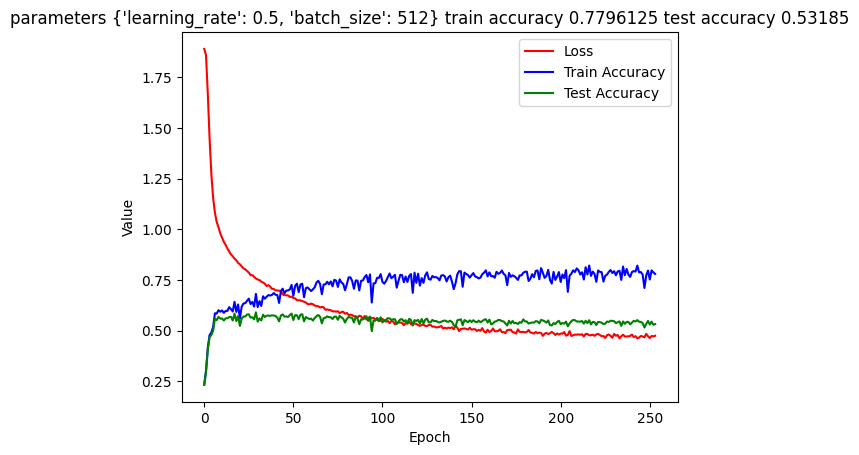

{'learning_rate': 0.9, 'batch_size': 256}
Epoch 1, Loss: 1.8234789371490479, Train Accuracy: 0.423675, Test Accuracy: 0.4131
Epoch 2, Loss: 1.4093103408813477, Train Accuracy: 0.51875, Test Accuracy: 0.50445
Epoch 3, Loss: 1.1840345859527588, Train Accuracy: 0.561775, Test Accuracy: 0.53955
Epoch 4, Loss: 1.0860952138900757, Train Accuracy: 0.5631125, Test Accuracy: 0.5394
Epoch 5, Loss: 1.025620937347412, Train Accuracy: 0.5986875, Test Accuracy: 0.5662
Epoch 6, Loss: 0.9786916971206665, Train Accuracy: 0.5988375, Test Accuracy: 0.5701
Epoch 7, Loss: 0.9485331177711487, Train Accuracy: 0.5848875, Test Accuracy: 0.5533
Epoch 8, Loss: 0.9223403930664062, Train Accuracy: 0.60335, Test Accuracy: 0.56475
Epoch 9, Loss: 0.9001381993293762, Train Accuracy: 0.625225, Test Accuracy: 0.5792
Epoch 10, Loss: 0.8839267492294312, Train Accuracy: 0.62925, Test Accuracy: 0.57615
Epoch 11, Loss: 0.8647903800010681, Train Accuracy: 0.6394125, Test Accuracy: 0.5892
Epoch 12, Loss: 0.8514807820320129, Tr

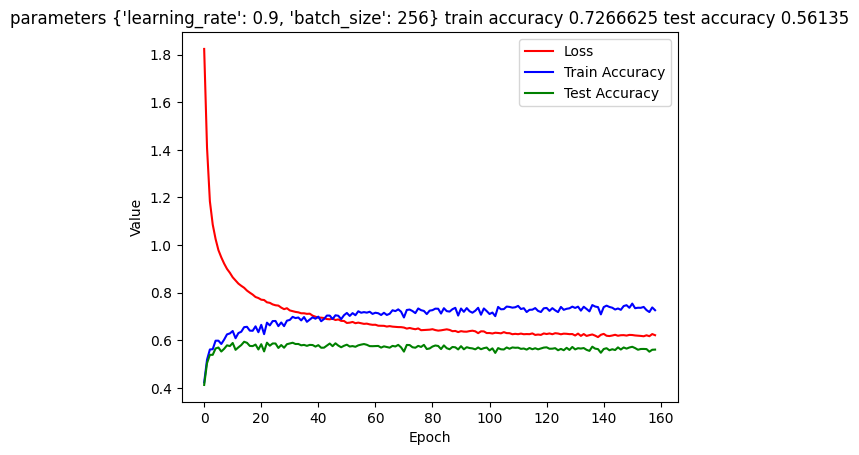

{'learning_rate': 0.7, 'batch_size': 256}
Epoch 1, Loss: 1.8482328653335571, Train Accuracy: 0.357825, Test Accuracy: 0.3491
Epoch 2, Loss: 1.4606077671051025, Train Accuracy: 0.5014125, Test Accuracy: 0.4871
Epoch 3, Loss: 1.1879754066467285, Train Accuracy: 0.575975, Test Accuracy: 0.5504
Epoch 4, Loss: 1.0824108123779297, Train Accuracy: 0.5813125, Test Accuracy: 0.55205
Epoch 5, Loss: 1.025647521018982, Train Accuracy: 0.5802, Test Accuracy: 0.5485
Epoch 6, Loss: 0.9816354513168335, Train Accuracy: 0.5994375, Test Accuracy: 0.56595
Epoch 7, Loss: 0.9460306167602539, Train Accuracy: 0.611375, Test Accuracy: 0.57695
Epoch 8, Loss: 0.9185017943382263, Train Accuracy: 0.5941, Test Accuracy: 0.5536
Epoch 9, Loss: 0.8961145281791687, Train Accuracy: 0.6267875, Test Accuracy: 0.58225
Epoch 10, Loss: 0.873631477355957, Train Accuracy: 0.6311125, Test Accuracy: 0.58405
Epoch 11, Loss: 0.8553248643875122, Train Accuracy: 0.632025, Test Accuracy: 0.58325
Epoch 12, Loss: 0.8393898010253906, Tr

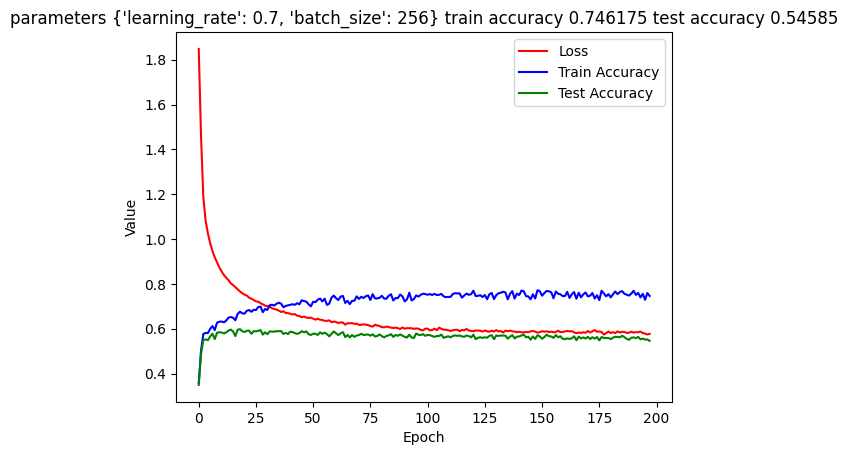

{'learning_rate': 0.2, 'batch_size': 256}
Epoch 1, Loss: 1.8904327154159546, Train Accuracy: 0.234625, Test Accuracy: 0.232
Epoch 2, Loss: 1.8730257749557495, Train Accuracy: 0.268625, Test Accuracy: 0.264
Epoch 3, Loss: 1.7315242290496826, Train Accuracy: 0.4243, Test Accuracy: 0.40665
Epoch 4, Loss: 1.5061070919036865, Train Accuracy: 0.4922625, Test Accuracy: 0.4794
Epoch 5, Loss: 1.3256107568740845, Train Accuracy: 0.532, Test Accuracy: 0.51665
Epoch 6, Loss: 1.197518229484558, Train Accuracy: 0.5524875, Test Accuracy: 0.5307
Epoch 7, Loss: 1.1092917919158936, Train Accuracy: 0.5886, Test Accuracy: 0.56075
Epoch 8, Loss: 1.0562701225280762, Train Accuracy: 0.591175, Test Accuracy: 0.56035
Epoch 9, Loss: 1.019675612449646, Train Accuracy: 0.597375, Test Accuracy: 0.56435
Epoch 10, Loss: 0.9925644397735596, Train Accuracy: 0.616625, Test Accuracy: 0.57845
Epoch 11, Loss: 0.967418909072876, Train Accuracy: 0.6245875, Test Accuracy: 0.58655
Epoch 12, Loss: 0.9501428604125977, Train Acc

KeyboardInterrupt: 

In [ ]:
torch.manual_seed(123)

# we loop through our hyperparameter list
for params in param_list:
  # print the parameters we're working with
  print(params)

  # we initialize our dataloader, varying our batch size
  train_loader = DataLoader(train_ds, batch_size=params['batch_size'], shuffle=True)
  test_loader = DataLoader(test_ds, batch_size=params['batch_size'], shuffle=True)

  # we initialze our model, optimizer, vary our learning rate, and set our number of epochs
  model = Connect4MLP()
  optimizer = torch.optim.SGD(model.parameters(), lr=params['learning_rate'])
  num_epochs = 500

  # variables for early stopping
  best_loss = float('inf')
  patience = 20
  epochs_without_improvement = 0

  # these will be used to make our graphs after each training loop
  loss_by_epoch = []
  train_accuracy_by_epoch = []
  test_accuracy_by_epoch = []

  # begin the training loop with the current hyperparameters
  for epoch in range(num_epochs):
    model = model.train()

    # we keep track of the losses by batch and begin loading our training data
    losses_by_batch = []
    for batch_idx, (boards, moves) in enumerate(train_loader):
      outputs = model(boards)
      loss = F.cross_entropy(outputs, moves.long())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      losses_by_batch.append(loss.item())

    # we populate the lists that will be used to create our graphs
    loss_by_epoch.append(float(torch.tensor(losses_by_batch).mean()))
    train_accuracy = compute_accuracy(model, train_loader)
    test_accuracy = compute_accuracy(model, test_loader)
    train_accuracy_by_epoch.append(train_accuracy)
    test_accuracy_by_epoch.append(test_accuracy)

    # this is for early stopping
    mean_loss_this_epoch = float(torch.tensor(losses_by_batch).mean())

    # keep track of our best model and whether or not we have exceeded our patience
    if mean_loss_this_epoch < best_loss:
      best_loss = mean_loss_this_epoch
      epochs_without_improvement = 0
        ()
    else:
      epochs_without_improvement += 1
      if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch + 1}.")
        break

    print(f"Epoch {epoch + 1}, Loss: {mean_loss_this_epoch}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}")

  # we plot our loss, train and test accuracy for these hyperparameters
  plt.plot(range(epoch + 1), loss_by_epoch, 'r', label='Loss')
  plt.plot(range(epoch + 1), train_accuracy_by_epoch, 'b', label='Train Accuracy')
  plt.plot(range(epoch + 1), test_accuracy_by_epoch, 'g', label='Test Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Value')
  plt.title(f'parameters {params} train accuracy {train_accuracy} test accuracy {test_accuracy}')
  plt.legend()
  plt.show()

  # keep track of our best accuracy and parameters
  if test_accuracy > best_accuracy:
    best_accuracy = test_accuracy
    best_params = params

  # clear the cache after each training loop for performance.
  torch.cuda.empty_cache()


print(f"Best Accuracy: {best_accuracy}, Best Parameters: {best_params}")


## Save our best model

In [ ]:
# restore the best model we found in all that
model.load_state_dict(best_model)
print(f'test accuracy {compute_accuracy(model, test_loader)}')
print(f'train accuracy {compute_accuracy(model, train_loader)}')
torch.save(model.state_dict(), 'connect4_model_v3.pth')

test accuracy 0.56305
train accuracy 0.7798625


# Human vs model game

## (OPTIONAL) Import existing model


In [ ]:
# import preexisting model
model = Connect4MLP()
# model = torch.load('connect4_model_v1.pth')
model.load_state_dict(torch.load('connect4_model_v3.pth'))

print(f'test accuracy {compute_accuracy(model, test_loader)}')
print(f'train accuracy {compute_accuracy(model, train_loader)}')

<ipython-input-16-6d8d80be4faf>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('connect4_model_v3.pth'))


test accuracy 0.5749
train accuracy 0.574275


In [ ]:
# Function to play a game between human and model
def human_vs_model_game():
    board = initialize_board()
    game_over = False
    human_player = -1  # Let's assign Player O (-1) to human
    model_player = 1  # Player X will be the model
    current_turn = rand.choice([human_player, model_player])  # Randomly decide who starts

    buttons = []
    for i in range(7):
        button = widgets.Button(description=str(i+1), layout=widgets.Layout(width='30px'))
        button.on_click(lambda b, col=i: drop_piece_and_print(board, col, current_turn))
        buttons.append(button)



    def drop_piece_and_print(board, col, piece):
        nonlocal current_turn, game_over
        if game_over:
            return

        if is_valid_location(board, col):
            row = get_next_open_row(board, col)
            drop_piece(board, row, col, piece)

            won, winning_coords = winning_move(board, current_turn)
            if won:
                clear_output()
                print_board(board, winning_coords)
                print(f"Player {current_turn} wins!")
                return current_turn  # Return the winning player

            valid_columns = [col for col in range(7) if is_valid_location(board, col)]

            # Switch players
            current_turn *= -1

            # model plays its move
            with torch.inference_mode():
              valid_columns = [col for col in range(7) if is_valid_location(board, col)]
              next_move = recommend_valid_move(board, valid_columns)

            row = get_next_open_row(board, next_move)
            drop_piece(board, row, next_move, model_player)

            won, winning_coords = winning_move(board, current_turn)
            if won:
                clear_output()
                print_board(board, winning_coords)
                print(f"Player {current_turn} wins!")
                return current_turn  # Return the winning player

            current_turn *= -1
            clear_output()
            print_board(board, [])
            display(widgets.HBox(buttons))

            print(f'model played {next_move + 1}')

    if current_turn == model_player:
        valid_columns = [col for col in range(7) if is_valid_location(board, col)]

        col = recommend_move(board)
        row = get_next_open_row(board, col)
        drop_piece(board, row, col, model_player)

        won, winning_coords = winning_move(board, model_player)
        if won:
            clear_output()
            print_board(board, winning_coords)
            print(f"Player O wins!")
            game_over = True

        # Switch turns
        current_turn *= -1

        # Check for draw
        if np.all(board != 0) and not game_over:
            print_board(board, [])
            print("The game ended in a draw.")
            game_over = True


    print_board(board, [])
    display(widgets.HBox(buttons))

# Run the game function to play against the model
human_vs_model_game()

. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . x o . . . 
. . x o o x . 



model played 3


# **Visualization**

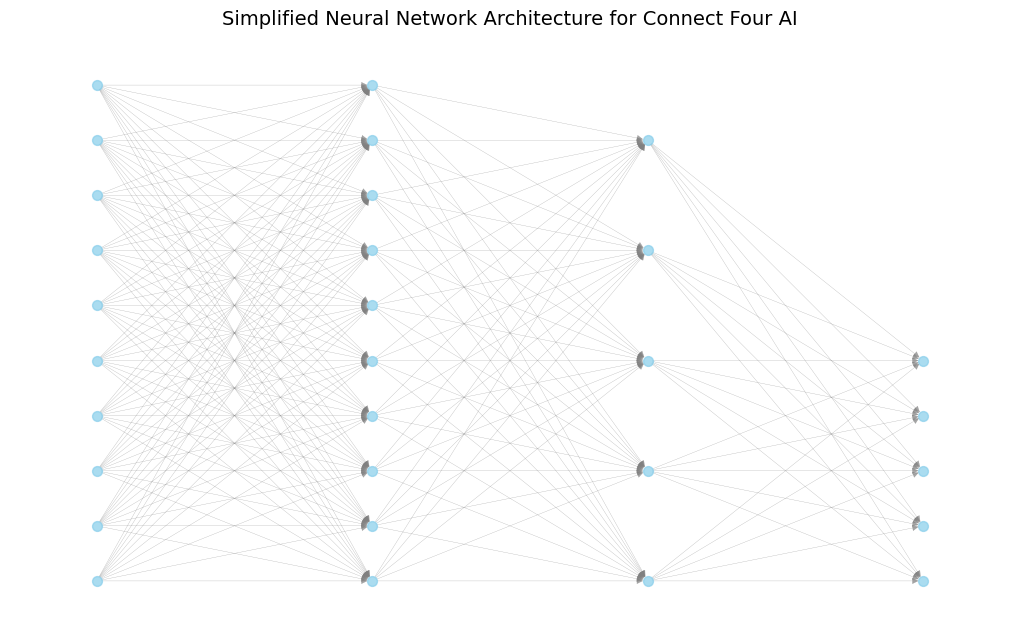

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Define the layers
input_nodes = range(42)  # 42 input nodes (flattened board)
hidden1_nodes = range(42, 170)  # First hidden layer nodes
hidden2_nodes = range(170, 298)  # Second hidden layer nodes
output_nodes = range(298, 305)  # 7 output nodes (one for each column)

# Create a drastically simplified graph with only a subset of each layer's nodes
simplified_input_nodes = list(input_nodes)[:10]  # First 10 input nodes
simplified_hidden1_nodes = list(hidden1_nodes)[:10]  # First 10 hidden layer 1 nodes
simplified_hidden2_nodes = list(hidden2_nodes)[:5]  # First 5 hidden layer 2 nodes
simplified_output_nodes = list(output_nodes)[:5]  # All 5 output nodes

# Create a new graph for visualization
G_simplified = nx.DiGraph()

# Add nodes to the graph
G_simplified.add_nodes_from(simplified_input_nodes, layer="Input")
G_simplified.add_nodes_from(simplified_hidden1_nodes, layer="Hidden1")
G_simplified.add_nodes_from(simplified_hidden2_nodes, layer="Hidden2")
G_simplified.add_nodes_from(simplified_output_nodes, layer="Output")

# Add edges to simulate connections between layers
for i in simplified_input_nodes:
    for h1 in simplified_hidden1_nodes:
        G_simplified.add_edge(i, h1)
for h1 in simplified_hidden1_nodes:
    for h2 in simplified_hidden2_nodes:
        G_simplified.add_edge(h1, h2)
for h2 in simplified_hidden2_nodes:
    for o in simplified_output_nodes:
        G_simplified.add_edge(h2, o)

# Define positions for the simplified graph
pos_simplified = {}
layer_gap = 3

# Input Layer
for i, node in enumerate(simplified_input_nodes):
    pos_simplified[node] = (0, i - len(simplified_input_nodes) // 2)

# Hidden Layer 1
for i, node in enumerate(simplified_hidden1_nodes):
    pos_simplified[node] = (
        layer_gap,
        (i * len(simplified_input_nodes) / len(simplified_hidden1_nodes)) - len(simplified_input_nodes) // 2,
    )

# Hidden Layer 2
for i, node in enumerate(simplified_hidden2_nodes):
    pos_simplified[node] = (
        layer_gap * 2,
        (i * len(simplified_hidden1_nodes) / len(simplified_hidden2_nodes)) - len(simplified_input_nodes) // 2,
    )

# Output Layer
for i, node in enumerate(simplified_output_nodes):
    pos_simplified[node] = (
        layer_gap * 3,
        (i * len(simplified_hidden2_nodes) / len(simplified_output_nodes)) - len(simplified_input_nodes) // 2,
    )

# Draw the simplified graph
plt.figure(figsize=(10, 6))
nx.draw(
    G_simplified,
    pos_simplified,
    with_labels=False,
    node_size=50,  # Smaller nodes
    alpha=0.7,
    node_color="skyblue",
    edge_color="gray",
    width=0.2,  # Thinner edges
)
plt.title("Simplified Neural Network Architecture for Connect Four AI", fontsize=14)
plt.show()
